In [240]:
import seaborn, pygraphviz, time, copy
import numpy as np, scipy as sp, pandas as pd, pymc as pm
from pomegranate import *
from matplotlib import pyplot as plt
from scipy.stats import multinomial

In [33]:
data = pd.read_csv('desktop/server_data.csv')

In [34]:
data = data[data.columns[2:]].drop(['cpuFreq'],axis=1)

In [37]:
data.columns[:4]

Index(['nbCurrent', 'cpuCurrent', 'cpuTemp', 'voltage0'], dtype='object')

 ## Generates probability distributions and random variables from existing dataset ##

In [38]:
def prob_gen(df):
    vals, probs = [], []
    for i in data.columns[:4]:
        vals += [df[i].unique()]  
        probs += [df[i].value_counts(normalize=True)]
    return vals, probs

In [39]:
def rv_gen(values, dist, length):
    temp = [dist[i] for i in values]
    return multinomial.rvs(n=1, p=temp, size=length)@np.array(values)

## Randomly generates shutdowns, failures in accordance with an existing "policy" ##

The "policy" is represented by the thresholds which are basically risk tolerances

Given the randomness nature of the shutdowns, we can blame this policy on differences between individual operators as opposed to a corporate (or data driven) policy

If the machine is at capacity level <= 12, we never shut down intentionally (and risk a 1% chance of failure)

If capacity > 12 and <= 15, we shut down 20% of the time and risk a 5% chance of failure

If capacity > 15, we shut down 94% of the time and risk a 5% chance of failure

In [247]:
def status_gen(df):
    m, n = df.shape
    state = np.sum(df[:],axis=1).astype(int)
    action, rewards = np.zeros(m), np.zeros(m)
    
    for x in range(len(state)):
        test = np.random.rand()
        if state[x] <= 12:
            if test > .99:
                action[x], rewards[x] = 0, -1000
            else:
                action[x], rewards[x] = 0, 1
        elif state[x] > 12 and state[x] <= 15:
            if test > .95:
                action[x], rewards[x] = 0, -1000
            elif test > .75 and test <= .95:
                action[x], rewards[x] = 1, -100
            else:
                action[x], rewards[x] = 0, 1
        else:
            if test > .95:
                action[x], rewards[x] = 0, -1000
            elif test > .01 and test <= .95:
                action[x], rewards[x] = 1, -100
            else:
                action[x], rewards[x] = 0, 1
    
    res = pd.DataFrame({'State':state.astype(int), 'Action':action.astype(int),\
                        'Reward':rewards.astype(int)})
    return res

In [248]:
def simulator(df, steps):
    vals, probs = prob_gen(data) 

    sim_data = pd.DataFrame(np.matrix([rv_gen(vals[x], probs[x], steps) for x in range(len(vals))]).T, \
                        columns=data.columns[:4])
    status_data = status_gen(sim_data)
    
    res = pd.concat([sim_data, status_data], axis=1)
    
    return res

In [249]:
steps = 1000000
res = simulator(data, steps)

res.head(5)

,nbCurrent,cpuCurrent,cpuTemp,voltage0,State,Action,Reward
0,2.0,3.0,2.0,0.0,7,0,1
1,3.0,3.0,6.0,2.0,14,0,1
2,1.0,3.0,1.0,0.0,5,0,1
3,7.0,3.0,1.0,0.0,11,0,1
4,1.0,3.0,1.0,0.0,5,0,1


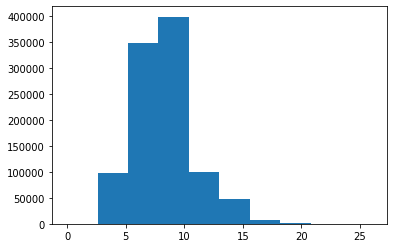

In [250]:
plt.hist(res.State)
plt.show()

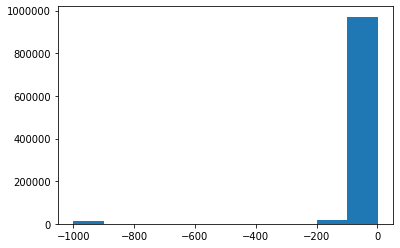

In [255]:
plt.hist(res.Reward)
plt.show()

In [256]:
pom_model = BayesianNetwork.from_samples(res, algorithm='exact')

((), (), (), (0, 2, 4), (0, 1, 2), (6,), (4,))


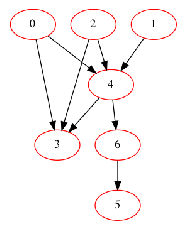

In [257]:
print(pom_model.structure)
pom_model.plot()

## State Space: possible values of capacity [0,28]##

## Action Space: 0(run), 1(take offline) ##

## Rewards: fail(-1000), taken offline(-100), run(1) ##

In [225]:
def Q_update(data, Q, alpha, gamma):
    r = 0
    for i in range(len(data)-1):
        s, a, r, s_prime = data.State[i], data.Action[i], data.Reward[i], data.State[i+1]
        Q[s, a] = Q[s, a] + alpha*(r + gamma*np.max(Q[s_prime]) - Q[s, a])
    return Q

In [262]:
def Q_learn(data, states, actions, iters, alpha, gamma):
    
    start = time.time()
    Q, Q_temp = np.zeros((states,actions)), np.zeros((states,actions))   
    Q = Q_update(data, Q, alpha, gamma)
    diff, i = 1, 0
    while diff > 0.1 and i < iters:
        Q = Q_update(data, Q, alpha, gamma)        
        diff = np.sum((Q_temp-Q)**2)
        i += 1
        Q_temp = copy.deepcopy(Q)
    iters = i
    
    policy = np.argmax(Q,axis=1)+1
    finish = time.time()
    print('Ran ', iters, 'iterations in ', round(finish-start,2), ' seconds \n')
    
    return Q, policy-1

In [258]:
Q, policy = Q_learn(res, 29, 2, 1000, 0.5, 0.9)

Ran  8 iterations in  851.07  seconds 



In [259]:
Q

array([[    5.52676147,     0.        ],
       [    2.51346742,     0.        ],
       [  -27.69713705,     0.        ],
       [    3.85518028,     0.        ],
       [    6.53952911,     0.        ],
       [    5.97717915,     0.        ],
       [    6.0040753 ,     0.        ],
       [    4.47847109,     0.        ],
       [    5.85992847,     0.        ],
       [    6.01048605,     0.        ],
       [    5.76718276,     0.        ],
       [    5.64945979,     0.        ],
       [    4.97743019,     0.        ],
       [    5.77015432,   -95.36848228],
       [    6.09739016,  -110.70669448],
       [    4.18305303,   -96.00489508],
       [ -866.43067024,   -97.46362405],
       [ -866.93948779,  -104.14299727],
       [ -701.07936909,   -96.89441343],
       [-1001.95659207,   -97.28234047],
       [ -996.87233637,   -97.86143741],
       [ -731.57952334,  -101.47510131],
       [    3.75327355,   -97.72604532],
       [    0.        ,   -97.44071463],
       [    0.  

In [261]:
policy-1

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0])

## Issues: ##

full state space not encountered in current sample - need to use estimates

policy at the upper bounds of state space seem sub-optimal. this is probably because the odds of getting there are so small

## Questions: ##

what is the optimal policy given this reward structure?

what is the sensitivity of policies to rewards? (i.e., what if reward for running was 10, offline 0, etc.)

    -what if management needed to ramp up production etc.?
    
is there an optimal policy across all reward structures?

what is the sensitivity of policy to discount / learning rates? 

